In [80]:
import pandas as pd
df = pd.read_csv('../dataset/DBPEDIA_train.csv')
document_list = df['text'].to_numpy().astype('str')
document_list.dtype

dtype('<U3944')

In [81]:
# # Tokenizeing documents
# from transformers import BertTokenizer
# tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
# encoded_list = []

# for i, doc in enumerate(document_list):
#     encoded = tokenizer.encode_plus(doc, add_special_tokens=True, max_length=512)
#     encoded_list.append(encoded)

In [82]:
# df['text'] = encoded_list

In [83]:
# encoding topics to create the adjacency matrix
from sklearn.preprocessing import LabelEncoder
import numpy as np

labelEncoder = LabelEncoder()
topics = np.concatenate((df['l1'].unique(), df['l2'].unique(), df['l3'].unique()))
labelEncoder.fit(topics)

def encode_topic(topic):
    print(type(topic))
    return labelEncoder.transform(topic)

df['l1_encoded'] = labelEncoder.transform(df['l1'])
df['l2_encoded'] = labelEncoder.transform(df['l2'])
df['l3_encoded'] = labelEncoder.transform(df['l3'])


In [84]:
graph_dict = {}

for i, row in df.iterrows():
    l1 = row['l1_encoded']
    l2 = row['l2_encoded']
    l3 = row['l3_encoded']

    if l1 not in graph_dict:
        graph_dict[l1] = {}
    if l2 not in graph_dict[l1]:
        graph_dict[l1][l2] = {} 

    graph_dict[l1][l2][l3] = 1

In [85]:
# creating adjacency matrix
adj_matrix = np.zeros((len(topics), len(topics)))
square_numeric_dict = {'source': [], 'target': []}
for i, df_row in df.iterrows():
    l1 = df_row['l1_encoded']
    l2 = df_row['l2_encoded']
    l3 = df_row['l3_encoded']

    adj_matrix[l1, l2] = 1
    adj_matrix[l2, l3] = 1

for i, row in enumerate(adj_matrix):
    for j, value in enumerate(row):
        if value == 0:
            continue
        square_numeric_dict['source'].append(i)
        square_numeric_dict['target'].append(j)

square_numeric_edges = pd.DataFrame(square_numeric_dict)

In [86]:
# creating node features
x = np.arange(298)
x = labelEncoder.inverse_transform(x)
feature_array = x.reshape(298, -1)

In [87]:
# loading GloVe model to get topic word embeddings
# from https://stackoverflow.com/questions/37793118/load-pretrained-glove-vectors-in-python
import torch
import torchtext

glove = torchtext.vocab.GloVe(name="6B", dim=50)

In [88]:
# Creating "ego-graphs" (each node is seperated into a graph with itself, parent, and siblings)
# The base node (so the node itself) will be masked, aka. have a [MASK] embedding
# The sibling nodes need to have a negative relationship with the base node (so negative value in adjacency matrix?)
from spektral.data import Graph
import numpy as np
import re
def create_ego_graph(l1_topic, l2_topic, l3_topic, graph_dict):
    if l3_topic != None:
        siblings_list = list(graph_dict[l1_topic][l2_topic].keys())
        siblings_list.remove(l3_topic)
        base = l3_topic
        parent = l2_topic
        grandparent = l1_topic

        all_nodes_list = siblings_list.copy()
        all_nodes_list.append(base)
        all_nodes_list.append(parent)
        all_nodes_list.append(grandparent)
        
        n_nodes = len(all_nodes_list)
        adj_matrix = np.zeros((n_nodes, n_nodes))

        node_label_encoder = LabelEncoder()
        node_label_encoder.fit(all_nodes_list)
        
        encoded_base = node_label_encoder.transform([base])[0]
        encoded_parent = node_label_encoder.transform([parent])[0]
        encoded_grandparent = node_label_encoder.transform([grandparent])[0]

        adj_matrix[encoded_base][encoded_parent] = 1
        adj_matrix[encoded_parent][encoded_base] = 1

        adj_matrix[encoded_grandparent][encoded_parent] = 1
        adj_matrix[encoded_parent][encoded_grandparent] = 1

        for sibling in siblings_list: 
            encoded_sibling = node_label_encoder.transform([sibling])[0]
            adj_matrix[encoded_sibling][encoded_base] = -1
            adj_matrix[encoded_base][encoded_sibling] = -1
        
    elif l2_topic != None:
        siblings_list = list(graph_dict[l1_topic].keys())
        siblings_list.remove(l2_topic)
        base = l2_topic
        parent = l1_topic

        all_nodes_list = siblings_list.copy()
        all_nodes_list.append(base)
        all_nodes_list.append(parent)
        
        n_nodes = len(all_nodes_list)
        adj_matrix = np.zeros((n_nodes, n_nodes))

        node_label_encoder = LabelEncoder()
        node_label_encoder.fit(all_nodes_list)
        
        encoded_base = node_label_encoder.transform([base])[0]
        encoded_parent = node_label_encoder.transform([parent])[0]

        adj_matrix[encoded_base][encoded_parent] = 1
        adj_matrix[encoded_parent][encoded_base] = 1

        for sibling in siblings_list: 
            encoded_sibling = node_label_encoder.transform([sibling])[0]
            adj_matrix[encoded_sibling][encoded_base] = -1
            adj_matrix[encoded_base][encoded_sibling] = -1
    
    elif l1_topic != None:
        siblings_list = list(graph_dict.keys())
        siblings_list.remove(l1_topic)
        base = l1_topic

        all_nodes_list = siblings_list.copy()
        all_nodes_list.append(base)
        
        n_nodes = len(all_nodes_list)
        adj_matrix = np.zeros((n_nodes, n_nodes))

        node_label_encoder = LabelEncoder()
        node_label_encoder.fit(all_nodes_list)
        
        encoded_base = node_label_encoder.transform([base])[0]

        for sibling in siblings_list: 
            encoded_sibling = node_label_encoder.transform([sibling])[0]
            adj_matrix[encoded_sibling][encoded_base] = -1
            adj_matrix[encoded_base][encoded_sibling] = -1

    ego_features = np.zeros((n_nodes, 50))
    encoded_nodes_list = node_label_encoder.transform(all_nodes_list)

    for i, node in enumerate(all_nodes_list):
        feature = feature_array[node]
        split_words_list = re.sub( r"([A-Z])", r" \1", feature[0]).split()
        n_words = len(split_words_list)
        embedding_avg = np.array([glove[word.lower()].numpy() for word in split_words_list]).sum(axis=0)/n_words
        
        # Masking base node, setting the embedding to all 0's
        if (node == base):
            embedding_avg = glove['MASK']

        ego_features[encoded_nodes_list[i]] = embedding_avg

    return Graph(a=adj_matrix, x=ego_features, y=(l1_topic, l2_topic, l3_topic))

graph_list = []

for l1_topic in graph_dict:
    for l2_topic in graph_dict[l1_topic]:
        for l3_topic in graph_dict[l1_topic][l2_topic]:
            graph_list.append(create_ego_graph(l1_topic, l2_topic, l3_topic, graph_dict))
        graph_list.append(create_ego_graph(l1_topic, l2_topic, None, graph_dict))
    graph_list.append(create_ego_graph(l1_topic, None, None, graph_dict))

graph_list = np.array(graph_list)

In [89]:
from spektral.data import Dataset

class MyDataset(Dataset):
    """
    """
    def __init__(self, graph_list: list[Graph], **kwargs):
        self.graph_list = graph_list
        super().__init__(**kwargs)

    def read(self):
        # We must return a list of Graph objects
        num_l =  np.random.permutation(len(self.graph_list))
        return [self.graph_list[i] for i in num_l]
    
dataset = MyDataset(graph_list)

In [90]:
from spektral.data import DisjointLoader, SingleLoader
from transformers import BertTokenizer

learning_rate = 1e-3  # Learning rate
epochs = 20  # Number of training epochs
batch_size = 32  # Batch size

# Train/test split
np.random.shuffle(dataset)
split = int(0.6 * len(dataset))
data_tr, data_te = dataset[:split], dataset[split:]

loader_tr = DisjointLoader(data_tr, batch_size=1, epochs=epochs)
loader_te = DisjointLoader(data_te, batch_size=1,)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

C:\Users\saif8\AppData\Local\Temp\ipykernel_19964\2831520202.py:9: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(dataset)


In [91]:
for x in loader_tr:
    y = x

c:\Users\saif8\miniconda3\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


In [103]:
y[1][0[]]

array([3, 123, None], dtype=object)

In [93]:
# Code from the tensorflow_ranking source code
# Source: https://github.com/tensorflow/ranking/blob/v0.5.2/tensorflow_ranking/python/keras/layers.py#L806-L891
# Need to modify code since the original implementation only takes two embeddings of the SAME shape
# For this case however, the topic embedding and the BERT embedding have two different shapes (50 x 768)
import tensorflow as tf

class Bilinear(tf.keras.layers.Layer):
  """A Keras Layer makes bilinear interaction of two vectors.
  This Keras Layer implements the bilinear interaction of two vectors of
  embedding dimensions. The bilinear, linear and scalar parameters of the
  interaction are trainable.
  The bilinear interaction are used in the work "Revisiting two tower models
  for unbiased learning to rank" by Yan et al, see
  https://research.google/pubs/pub51296/.
  In this work, the bilinear interaction appears to be helpful in model the
  complex interaction between position and relevance in unbiased LTR.
  """

  def __init__(self, embedding1_dim: int, embedding2_dim: int, output_dim: int, **kwargs: dict[any,
                                                                         any]):
    """Initializer.
    Args:
      embedding_dim: An integer that indicates the embedding dimension of the
        interacting vectors.
      output_dim: An integer that indicates the output dimension of the layer.
      **kwargs: A dict of keyword arguments for the tf.keras.layers.Layer.
    """
    super().__init__(**kwargs)
    self._embedding1_dim = embedding1_dim
    self._embedding2_dim = embedding2_dim
    self._output_dim = output_dim

  def build(self, input_shape: tf.TensorShape):
    """See tf.keras.layers.Layer."""
    # Create a trainable weight variable for this layer.
    self._bilinear_weight = self.add_weight(
        name='bilinear_term',
        shape=(self._output_dim, self._embedding1_dim, self._embedding2_dim),  # shape = (output_dim, embedding_1_dim, embedding_2_dim)
        initializer=tf.keras.initializers.RandomNormal(stddev=1. / self._embedding1_dim),
        trainable=True)
    
    self._bias = self.add_weight(
        name='const_term',
        shape=(self._output_dim),
        initializer=tf.keras.initializers.Zeros(),
        trainable=True)
    super().build(input_shape)

  def call(self, inputs: tuple[tf.Tensor]) -> tf.Tensor:
    """Computes bilinear interaction between two vector tensors.
    Args:
      inputs: A pair of tensors of the same shape [batch_size, embedding_dim].
    Returns:
      A tensor, of shape [batch_size, output_dim], computed by the bilinear
      interaction.
    """
    # Input of the function must be a list of two tensors.
    vec_1, vec_2 = inputs
    return tf.einsum(
        'bk,jkl,bl->bj', vec_1, self._bilinear_weight, vec_2) + self._bias

  def compute_output_shape(self, input_shape: tf.TensorShape) -> tuple[int]:
    """See tf.keras.layers.Layer."""
    return (input_shape[0], self._output_dim)

  def get_config(self) -> dict[str, any]:
    """See tf.keras.layers.Layer."""
    config = super().get_config()
    config.update({
        'embedding1_dim': self._embedding1_dim,
        'embedding2_dim': self._embedding2_dim,
        'output_dim': self._output_dim
    })
    return config

In [94]:
def sequence_to_document_embedding(sequence_embedding: tf.Tensor):
    # gets the document representation/embedding from a BERT sequence embedding
    # by getting the mean-pooling of the sequence 
    return tf.math.reduce_mean(sequence_embedding, axis=1)

class TopicAttentiveEmbedding(tf.keras.layers.Layer):
    # Layer for calculating the beta/topic-attentive representation (check TopicExpan paper) of the topic and document embedding
    # aka. softmax of the bilinear interaction of the topic embedding with the embedding of each word in the document
    # needs to use the same trained weights as the bilinear layer in the Similarity Predictor
    def __init__(self,  **kwargs):
        super().__init__(**kwargs)

    def call(self, inputs: tuple[tf.Tensor, tf.Tensor, tf.keras.layers.Layer]):
        # topic_embedding shape = (batch_size, topic_embedding_len)
        # sequence_embedding shape = (batch_size, 32, 768)
        topic_embedding, sequence_embedding, shared_bilinear_layer = inputs

        reshaped_topic_embedding: tf.Tensor = tf.reshape(topic_embedding, (-1, 1, topic_embedding.shape[1]))
        reshaped_topic_embedding: tf.Tensor = tf.repeat(reshaped_topic_embedding, sequence_embedding.shape[1], axis=1)

        def apply_bilinear(embeddings: tuple[tf.Tensor, tf.Tensor]):
            emb1, emb2 = embeddings
            bilinear_embedding = tf.reshape(shared_bilinear_layer([emb1, emb2], training=False), shape=[-1])
            softmax_bilinear_embedding = tf.nn.softmax(bilinear_embedding)
            return softmax_bilinear_embedding
        
        beta_embedding = tf.map_fn(
            apply_bilinear, 
            elems=(reshaped_topic_embedding, sequence_embedding),
            fn_output_signature=tf.TensorSpec(shape=(sequence_embedding.shape[1]))
        )
        
        return beta_embedding
    
class ContextEmbedding(tf.keras.layers.Layer):
    # Layer for calculating the context (Q) representation (check TopicExpan paper) of the topic and document embedding
    # aka. the beta representation (which combines the topic and document representations) multiplied by the respective
    # word in the document representation
    def __init__(self,  **kwargs):
        super().__init__(**kwargs)

    def call(self, inputs: tuple[tf.Tensor, tf.Tensor]):
        topic_attentive_embedding, sequence_embedding = inputs
        context_embedding = tf.multiply(sequence_embedding, topic_attentive_embedding)
        return context_embedding
    
def calculate_infoNCE_loss(inputs, temperature: float):
    # Split the inputs into the anchor and positive samples
    anchor, positive = tf.split(inputs, 2, axis=0)

    # Concatenate the anchor and positive samples along the batch axis
    concat = tf.concat([anchor, positive], axis=0)

    # Compute the labels
    batch_size = tf.shape(concat)[0]
    labels = tf.range(batch_size)
    masks = tf.one_hot(labels, batch_size * 2)

    # Compute the loss
    logits = logits / temperature
    loss = tf.nn.softmax_cross_entropy_with_logits(labels=masks, logits=logits)
    loss = tf.reduce_sum(loss)

    return loss

In [113]:
from tensorflow import int64
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Lambda
from spektral.layers import GCNConv, GlobalAvgPool
import tensorflow as tf

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import categorical_accuracy
import tensorflow as tf
from transformers import TFBertModel
import keras_nlp

optimizer = Adam(learning_rate)
loss_fn = CategoricalCrossentropy()
 
n_out = dataset.n_labels
topic_embedding_dimension = 50

In [114]:
# Custom training loop
class ModelWithNCE(Model):
    @tf.function(experimental_relax_shapes=True)
    def train_step(self, data):
        # print(data)
        inputs, target = data
        with tf.GradientTape() as tape:
            predictions = self(inputs, training=True)
            # infonce_loss = 
            loss = loss_fn(target, predictions) + sum(self.losses)
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        self.compiled_metrics.update_state(target, predictions)
        return {m.name: m.result() for m in self.metrics}

In [107]:
import math

class TopicExpanTrainGen(tf.keras.utils.Sequence):
    # Creating a custom Keras generator for model.fit()
    # Splits batches into mini-batches of size (mini_batch_size)
    # batch size must be a multiple of mini_batch_size
    def __init__(self, topic_graph_loader: DisjointLoader, document_input: np.array, document_topics: np.array, batch_size: int, mini_batch_size: int):
        if batch_size % mini_batch_size != 0:
            raise Exception('batch size must be a multiple of mini_batch_size')
        
        self._graph_loader = topic_graph_loader
        self.document_input = document_input
        self.document_topics = document_topics
        self.batch_size = batch_size
        self.mini_batch_size = mini_batch_size
        # used for creating batches (to get random documents for the negative samples of the batch)
        self.document_topics_dict = {}
        for i, topic in enumerate(document_topics):
            if topic not in self.document_topics_dict:
                self.document_topics_dict[topic] = [i]

            self.document_topics_dict[topic].append(i)

        # ego-graph list
        self.graph_features = []
        # maps a topic to its ego-graph
        self.topic_to_graph_dict = {}

        for graph, label in topic_graph_loader:
            self.graph_features.append(graph)
            self.topic_to_graph_dict[label] = graph

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, non_batch_index: int):
        idx = non_batch_index * (self.batch_size / self.mini_batch_size)
    
        batch_graph_list = []
        batch_document_list = []
        batch_document_label = []
        batch_phrase = []
        for mini_batch in range(self.batch_size / self.mini_batch_size):
            # TODO: add the phrases to return when done with dataset and topic tokenizatons
            positive_doc_topic = [self.document_topics[idx] + mini_batch]
            positive_document = [self.document_input[idx] + mini_batch]
            positive_graph = self.topic_to_graph_dict[positive_doc_topic]

            exclude_list = [positive_doc_topic]
            negative_documents = []
            for _ in range(self.mini_batch_size-1):
                random_negative_topic = np.random.choice(list(set([x for x in range(0, self.document_topics.max)]) - set([positive_doc_topic])))
                exclude_list.append(random_negative_topic)

                random_negative_document = np.random.choice(self.document_topics_dict[random_negative_topic])
                negative_documents.append(random_negative_document)

            mini_batch_graph_list = np.array([positive_graph for _ in range(self.mini_batch_size)])
            mini_batch_document_list = np.array(positive_document + negative_documents)
            mini_batch_document_label = np.zeros(mini_batch)
            mini_batch_document_label[0] = 1
        # negative_doc_topics = 

        # batch_x = self.x[idx * self.batch_size:(idx + 1) *
        # self.batch_size]
        # batch_y = self.y[idx * self.batch_size:(idx + 1) *
        # self.batch_size]
        

        # return np.array([
        #     resize(imread(file_name), (200, 200))
        #        for file_name in batch_x]), np.array(batch_y)
    


In [126]:
a = np.array([])
np.append(a, np.array([[1, 2], [2, 3], [3, 4], [4, 5]]))

array([1., 2., 2., 3., 3., 4., 4., 5.])

In [109]:
################################################################################
# Build model
################################################################################
# shared bilinear layer (used in Similarity Predictor and Phrase Generator)
shared_bilinear = Bilinear(topic_embedding_dimension, 768, 1)

# GNNs (Topic Encoder)
X_in = Input(shape=(dataset.n_node_features))
A_in = Input(shape=(None,), sparse=True)
I_in = Input(shape=(), dtype=int64)

X = GCNConv(topic_embedding_dimension, activation='relu')([X_in, A_in])
X = GCNConv(topic_embedding_dimension, activation='relu')([X, A_in])
topic_embedding = GlobalAvgPool(name='topic_embedding')([X, I_in])

# BERT Embedding (Document Encoder)
max_len = 32
max_seq_length = max_len
encoder = TFBertModel.from_pretrained('bert-base-uncased')

vocab_size = tokenizer.vocab_size

input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
embedding = encoder(input_ids)[0]

# Transformer Decoders (Phrase Generator)

# Getting context embedding for decoder
topic_attentive_embedding = TopicAttentiveEmbedding()([topic_embedding, embedding, shared_bilinear], training=False)
topic_attentive_embedding = tf.keras.layers.Reshape((max_len, 1))(topic_attentive_embedding)
context_embedding = ContextEmbedding()([topic_attentive_embedding, embedding])

transformer_decoder = keras_nlp.layers.TransformerDecoder(
    num_heads=12, 
    intermediate_dim=max_seq_length,
    dropout=0.1
)(context_embedding)
transformer_decoder = keras_nlp.layers.TransformerDecoder(
    num_heads=12, 
    intermediate_dim=max_seq_length,
    dropout=0.1
)(context_embedding, transformer_decoder)
transformer_decoder = keras_nlp.layers.TransformerDecoder(
    num_heads=12, 
    intermediate_dim=max_seq_length,
    dropout=0.1
)(context_embedding, transformer_decoder)

# Transformer Output
out2 = Dense(vocab_size)(transformer_decoder)

# Output Bilinear layer (Similarity Predictor)
document_embedding = Lambda(sequence_to_document_embedding, name='document_embedding')(embedding)
out = shared_bilinear([topic_embedding, document_embedding])

# Outputs
model = ModelWithNCE(inputs=[X_in, A_in, I_in, input_ids], outputs=[out, out2])

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


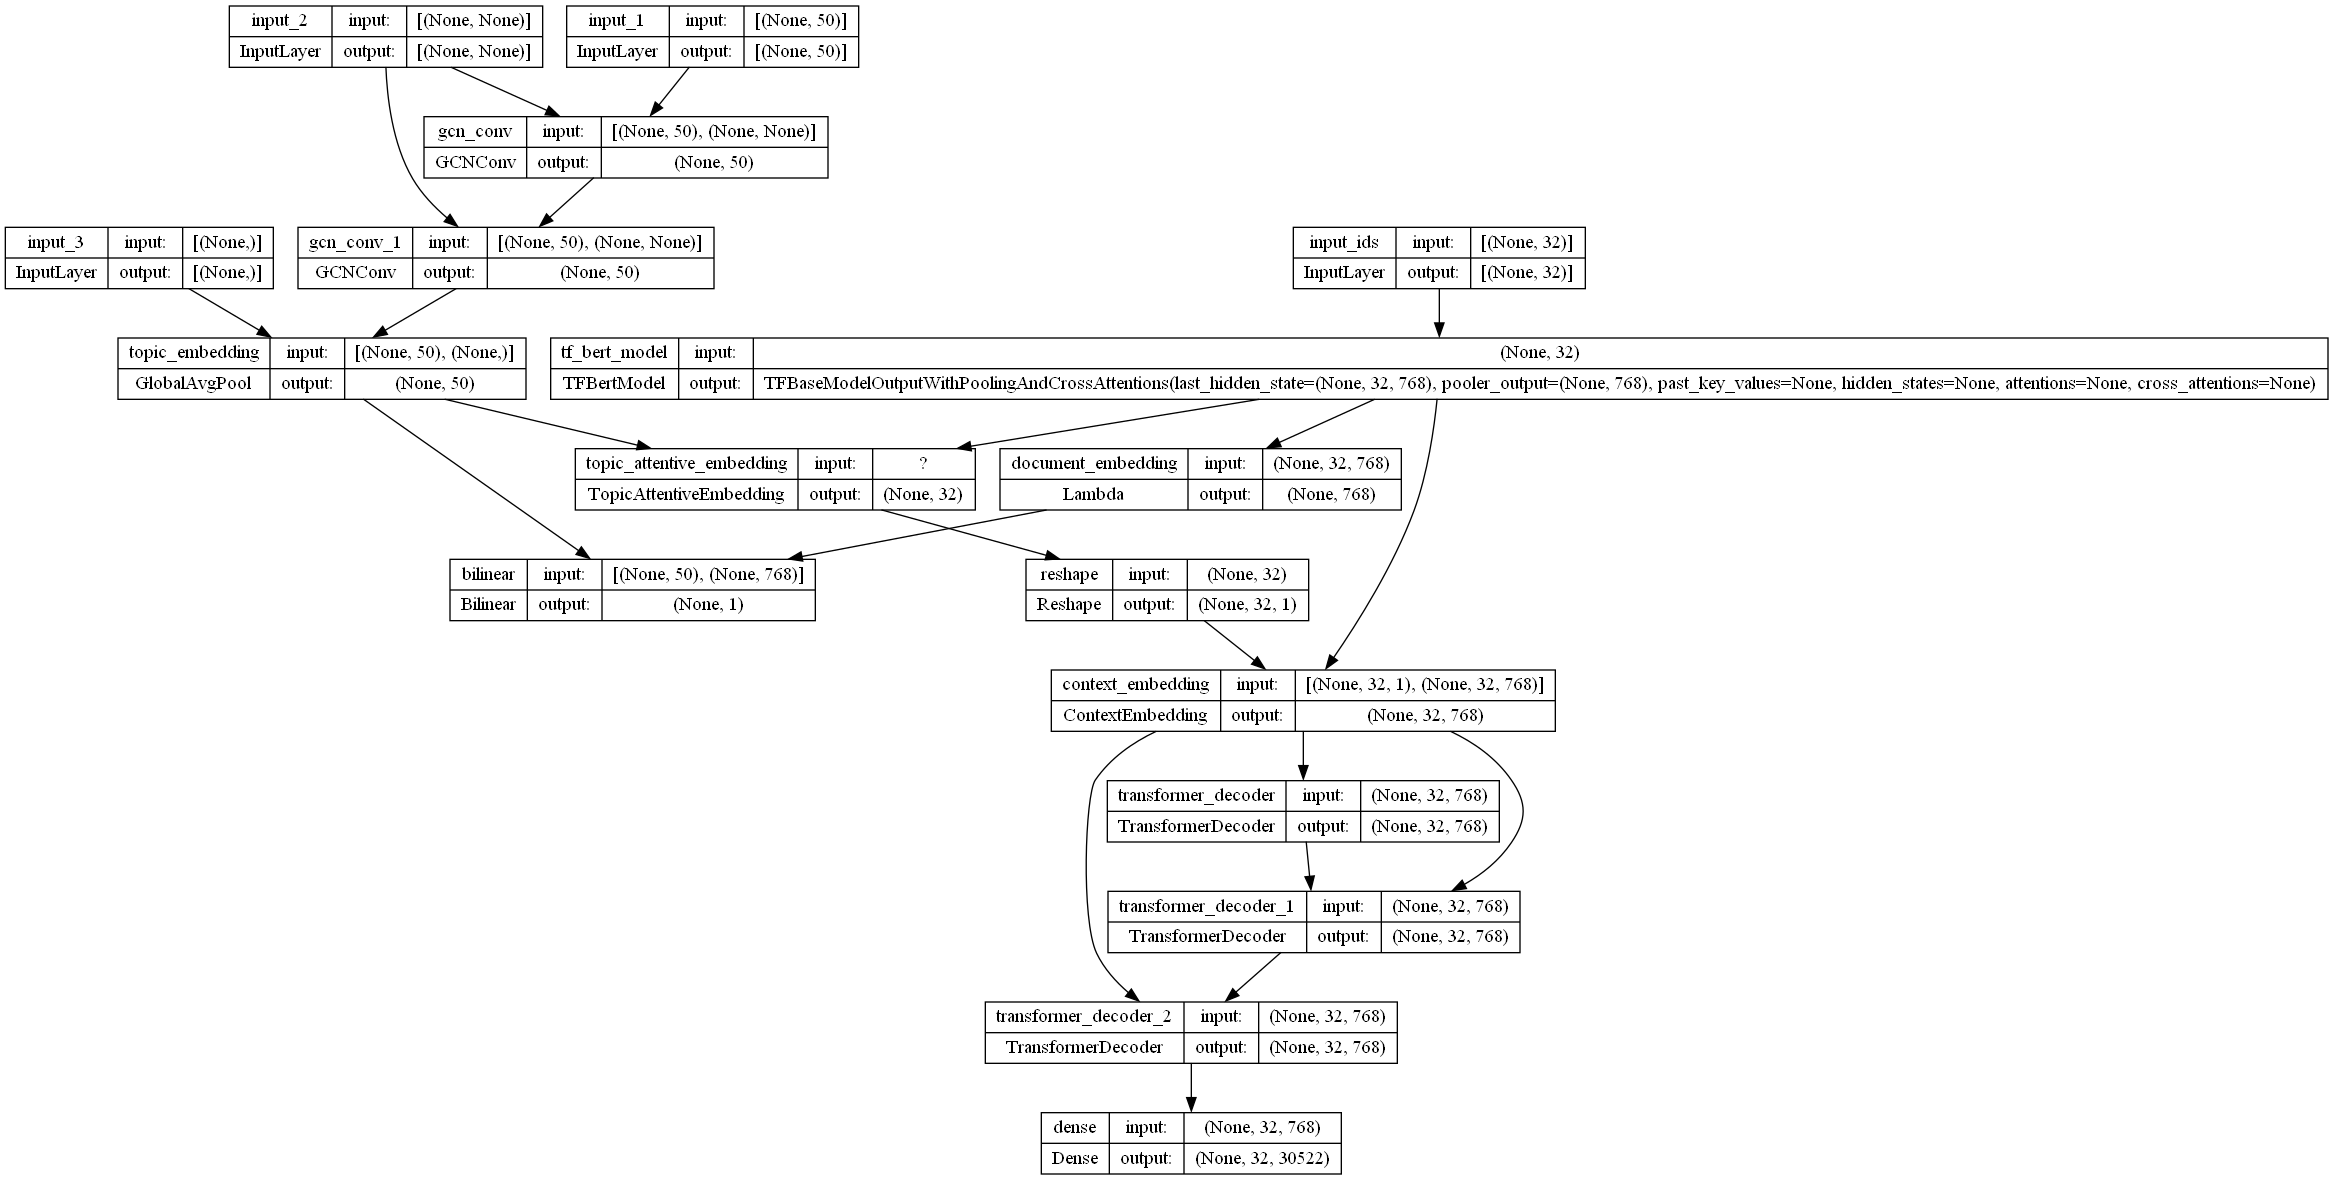

In [110]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [111]:
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'], run_eagerly=True)
model.summary()
# model.fit(loader_tr.load(), steps_per_epoch=loader_tr.steps_per_epoch, epochs=epochs)

Model: "model_with_nce"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 gcn_conv (GCNConv)             (None, 50)           2550        ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 gcn_conv_1 (GCNConv)           (None, 50)           2550        ['gcn_conv[0][0]',  

In [112]:
################################################################################
# Evaluate model
################################################################################
print("Testing model")
loss = model.evaluate(loader_te.load(), steps=loader_te.steps_per_epoch)
print("Done. Test loss: {}".format(loss))

Testing model


c:\Users\saif8\miniconda3\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


ValueError: Layer "model_with_nce" expects 4 input(s), but it received 3 input tensors. Inputs received: [<tf.Tensor: shape=(21, 50), dtype=float64, numpy=
array([[ 2.38529995e-01,  3.48879993e-01, -7.07539991e-02, ...,
         8.30619991e-01, -2.39289999e-01,  1.19430006e+00],
       [ 7.93960004e-04,  9.91180003e-01, -5.27469993e-01, ...,
         3.71140003e-01, -7.63800025e-01,  3.84449989e-01],
       [ 3.75779986e-01,  6.92749977e-01, -3.32839996e-01, ...,
        -6.89909995e-01,  7.94669986e-02,  4.66509998e-01],
       ...,
       [-5.38190007e-01,  8.93180013e-01, -6.79690003e-01, ...,
        -8.92610028e-02,  2.30460003e-01, -5.17610013e-01],
       [-3.59389991e-01,  4.37259972e-01, -1.93752497e-01, ...,
        -9.70730066e-01,  3.39240015e-01,  3.74825001e-02],
       [-3.29490006e-01,  4.85219985e-01, -1.17900002e+00, ...,
         1.38119996e-01, -4.46649998e-01, -1.10010004e+00]])>, <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x0000025EC6D56070>, <tf.Tensor: shape=(21,), dtype=int64, numpy=
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int64)>]

In [ ]:
################################################################################
# Build model
################################################################################
from tensorflow import int64
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
import tensorflow_ranking

from spektral.layers import GCNConv, GlobalAvgPool, GraphMasking

# n_out = dataset.n_labels

X_in = Input(shape=(50))
A_in = Input(shape=(None,), sparse=True)
I_in = Input(shape=(), dtype=int64)

X = GCNConv(32, activation='relu')([X_in, A_in])
X = GCNConv(32, activation='relu')([X, A_in])
X = GlobalAvgPool()([X, I_in])

shared_bilinear = tensorflow_ranking.keras.layers.Bilinear(32, 32)
X_1 = shared_bilinear([X, X])
X = shared_bilinear([X, X], training=False)

out = Dense(2, activation='softmax')(X)

model = Model(inputs=[X_in, A_in, I_in], outputs=out)


In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


c:\Users\saif8\miniconda3\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


AttributeError: 'tuple' object has no attribute 'shape'